Prepare ShapeNet Data:
Download ShapeNet point clouds or convert from meshes using tools like trimesh
Save each point cloud as a .npy file in a structured directory

Training:
Update "path_to_shapenet_point_clouds" in the dataset initialization
Run train_point_cloud_gan()
Monitor losses and visualize generated samples

Generation:
After training, load the generator:
////
global_generator = Generator().to(device)
generator.load_state_dict(torch.load("generator.pth"))
Generate new point clouds:
///
z = torch.randn(1, latent_dim).to(device)
new_pc = global_generator(z).cpu().numpy()[0]
visualize_point_cloud(new_pc)

---

Imports and Setup

In [1]:
import os
import ot
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import open3d as o3d
import torch.nn as nn
import traceback
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from torch.nn.utils import spectral_norm
import pandas as pd
import shutil


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Database conversion
The original dataset contains files in .off file format, which is incompatible with the subsequent code.\
This chunk of code converts them into .npy file format, compatible with the subsequent code.

Gloabl Variables

In [2]:
# Global variables
generator = None
latent_dim = None

Utility Functions 

In [3]:
def save_point_cloud(points, filename):
    """ Save point cloud to PLY file """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(filename, pcd)

def visualize_point_cloud(points):
    """ Interactive visualization """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])

Dataset Class

In [4]:
class PointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=2048, split='train'):
        self.root_dir = root_dir
        self.num_points = num_points
        self.files = []
        
        if not os.path.exists(root_dir):
            raise ValueError(f"Directory {root_dir} does not exist")
            
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith('.npy'):
                        self.files.append(os.path.join(class_path, file))
        
        if len(self.files) == 0:
            raise ValueError(f"No .npy files found in {root_dir}")

        split_idx = int(0.8 * len(self.files))
        self.files = self.files[:split_idx] if split == 'train' else self.files[split_idx:]
        np.random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            pc = np.load(self.files[idx], allow_pickle=True)

            if pc.shape[0] > self.num_points:
                idxs = np.random.choice(pc.shape[0], self.num_points, replace=False)
                pc = pc[idxs]
            elif pc.shape[0] < self.num_points:
                idxs = np.random.choice(pc.shape[0], self.num_points, replace=True)
                pc = pc[idxs]

            pc = torch.from_numpy(pc).float()
            pc = self.normalize_point_cloud(pc)
            return pc

        except Exception as e:
            print(f"Error loading index {idx}, file: {self.files[idx]}")
            print(f"Exception: {e}")
            return torch.zeros((self.num_points, 3))  # or raise the error again 

    def normalize_point_cloud(self, pc):
        """ Normalize point cloud to fit in [-1, 1] cube """
        centroid = torch.mean(pc, dim=0)
        pc = pc - centroid
        max_dist = torch.max(torch.sqrt(torch.sum(pc**2, dim=1)))
        pc = pc / max_dist
        return pc

Model Definitions 

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_points):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_points = num_points
        
        # Fully connected layers with batch norm and leaky ReLU
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            
            # Final layer outputs 3D coordinates (x,y,z) for each point
            nn.Linear(2048, num_points * 3),
            nn.Tanh()  # Tanh keeps outputs in [-1,1] range
        )

    def forward(self, z):
        batch_size = z.size(0)
        # Generate point cloud
        pc = self.model(z)
        # Reshape to [batch_size, num_points, 3]
        pc = pc.view(batch_size, self.num_points, 3)
        return pc

class Discriminator(nn.Module):
    def __init__(self, num_points=2048):
        super(Discriminator, self).__init__()
        self.num_points = num_points
        
        # Shared MLP layers (similar to PointNet)
        self.conv1 = spectral_norm(nn.Conv1d(3, 64, 1))  # Input channels: 3 (x,y,z), output: 64
        self.conv2 = spectral_norm(nn.Conv1d(64, 128, 1))
        self.conv3 = spectral_norm(nn.Conv1d(128, 256, 1))

        self.global_conv = spectral_norm(nn.Conv1d(256, 512, 1))
    
        
        # Classification layers
        self.fc1 = spectral_norm(nn.Linear(512, 256))
        self.fc2 = spectral_norm(nn.Linear(256, 1))

        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        # x shape: (batch_size, num_points, 3)
        x = x.transpose(2, 1)  # Convert to (batch_size, 3, num_points)
        
        # Shared MLP
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.global_conv(x))
        
        x = torch.max(x, 2, keepdim=True)[0]  # Global max pooling
        x = x.view(-1, 512)
        x = self.relu(self.fc1(x))
        x=self.fc2(x)
        
        return x

Training Utilities

In [6]:
def gradient_penalty(discriminator, real_samples, fake_samples, device):
    """ Calculates the gradient penalty loss for WGAN-GP """
    batch_size = real_samples.size(0)
    # Random weight term for interpolation
    alpha = torch.rand(batch_size, 1, 1).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(batch_size, 1).to(device)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Evaluation Metrics

In [7]:
def chamfer_distance(pc1, pc2):
    """Compute Chamfer Distance between two point clouds"""
    dist = cdist(pc1, pc2)
    return np.mean(np.min(dist, axis=0)) + np.mean(np.min(dist, axis=1))

def earth_movers_distance(pc1, pc2):
    """Approximate EMD using the Sinkhorn algorithm"""
    from ot import emd
    # Normalize to probability distributions
    pc1 = pc1 / np.sum(pc1, axis=1, keepdims=True)
    pc2 = pc2 / np.sum(pc2, axis=1, keepdims=True)
    cost_matrix = cdist(pc1, pc2)
    return emd([], [], cost_matrix)

def evaluate_model(global_generator, global_latent_dim, real_dataset, num_samples=100, device='cuda'):
    """Comprehensive evaluation of generated samples"""
    global_generator.eval()
    
    # Generate samples
    fake_pcs = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, global_latent_dim).to(device)
            fake_pc = global_generator(z).cpu().numpy()[0]
            fake_pcs.append(fake_pc)
    
    # Get real samples
    real_pcs = [real_dataset[i].numpy() for i in range(num_samples)]
    
    # Compute metrics
    cd_scores, emd_scores = [], []
    for real_pc, fake_pc in zip(real_pcs, fake_pcs):
        cd_scores.append(chamfer_distance(real_pc, fake_pc))
        emd_scores.append(earth_movers_distance(real_pc, fake_pc))
    
    return {
        'chamfer_distance': np.mean(cd_scores),
        'earth_movers_distance': np.mean(emd_scores),
        'samples': (real_pcs, fake_pcs)
    }

Visualization Functions

In [8]:
def visualize_comparison(real_pc, fake_pc, save_path=None):
    """Visualize real vs generated point clouds side by side"""
    fig = plt.figure(figsize=(12, 6))
    
    # Real point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(real_pc[:,0], real_pc[:,1], real_pc[:,2], s=1)
    ax1.set_title('Real Point Cloud')
    ax1.set_axis_off()
    
    # Generated point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(fake_pc[:,0], fake_pc[:,1], fake_pc[:,2], s=1)
    ax2.set_title('Generated Point Cloud')
    ax2.set_axis_off()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def generate_and_save_samples(global_generator, global_latent_dim, num_samples=5, device='cuda'):
    """Generate and save sample point clouds"""
    global_generator.eval()
    os.makedirs('samples', exist_ok=True)
    
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, global_latent_dim).to(device)
            pc = global_generator(z).cpu().numpy()[0]
            
            # Save as PLY and PNG
            save_path = f'samples/sample_{i}'
            save_point_cloud(pc, f'{save_path}.ply')
            
            # Create visualization
            fig = plt.figure(figsize=(6,6))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=1)
            ax.set_axis_off()
            plt.savefig(f'{save_path}.png', bbox_inches='tight', dpi=150)
            plt.close()

 Enhanced Evaluation Metrics Implementation

In [9]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

def chamfer_distance(pc1, pc2):
    """Compute Chamfer Distance between two point clouds"""
    dist = cdist(pc1, pc2)
    return np.mean(np.min(dist, axis=0)) + np.mean(np.min(dist, axis=1))

def earth_movers_distance(pc1, pc2):
    """Approximate EMD using the Sinkhorn algorithm"""
    from ot import emd
    # Normalize to probability distributions
    pc1 = pc1 / np.sum(pc1, axis=1, keepdims=True)
    pc2 = pc2 / np.sum(pc2, axis=1, keepdims=True)
    cost_matrix = cdist(pc1, pc2)
    return emd([], [], cost_matrix)

def evaluate_model(global_generator, global_latent_dim, real_dataset, num_samples=100, device='cuda'):
    """Comprehensive evaluation of generated samples"""
    global_generator.eval()
    
    # Generate samples
    fake_pcs = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, global_latent_dim).to(device)
            fake_pc = global_generator(z).cpu().numpy()[0]
            fake_pcs.append(fake_pc)
    
    # Get real samples
    real_pcs = [real_dataset[i].numpy() for i in range(num_samples)]
    
    # Compute metrics
    cd_scores, emd_scores = [], []
    for real_pc, fake_pc in zip(real_pcs, fake_pcs):
        cd_scores.append(chamfer_distance(real_pc, fake_pc))
        emd_scores.append(earth_movers_distance(real_pc, fake_pc))
    
    return {
        'chamfer_distance': np.mean(cd_scores),
        'earth_movers_distance': np.mean(emd_scores),
        'samples': (real_pcs, fake_pcs)
    }

Training Function

In [ ]:
def train_point_cloud_gan():
    global global_generator, global_latent_dim 
    # Hyperparameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_latent_dim = 62
    num_points = 2048
    batch_size = 64
    epochs = 5
    lr = 0.0002
    n_critic = 3
    lambda_gp = 10

    # loss tracking
    gen_losses = []
    disc_losses = []
    
    # Debug setup
    import gc
    def print_memory():
        if torch.cuda.is_available():
            print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.memory_reserved()/1e9:.2f}GB")
        gc.collect()

    # Create dataset and dataloader
    try:
        dataset = PointCloudDataset("C:/Users/Edoardo/Desktop/chair", num_points=num_points)
        eval_dataset = PointCloudDataset("C:/Users/Edoardo/Desktop/chair", num_points=num_points, split='test')
        print(f"Dataset loaded with {len(dataset)} samples (train), {len(eval_dataset)} samples (test)")

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        print(f"Dataloader created with {len(dataloader)} batches of size {batch_size}")
    except Exception as e:
        print(f"Error initializing data: {e}")
        return

    # Initialize networks
    global_generator = Generator(global_latent_dim, num_points).to(device)
    discriminator = Discriminator(num_points).to(device)
    global_generator.train()
    discriminator.train()

    # Optimizers
    optimizer_G = torch.optim.Adam(global_generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Training loop with enhanced monitoring
    try:
        for epoch in range(epochs):
            print(f"\n--- Starting Epoch {epoch+1}/{epochs} ---")
            print_memory()
            
            for i, real_pcs in enumerate(tqdm(dataloader)):
                # Skip any problematic batches
                if real_pcs.size(0) != batch_size:
                    print(f"\nSkipping incomplete batch of size {real_pcs.size(0)}")
                    continue
                    
                real_pcs = real_pcs.to(device)
                
                # Train Discriminator
                optimizer_D.zero_grad()
                
                # Generate fake point clouds
                z = torch.randn(batch_size, global_latent_dim).to(device)
                fake_pcs = global_generator(z)
                
                # Real and fake losses
                real_loss = -torch.mean(discriminator(real_pcs))
                fake_loss = torch.mean(discriminator(fake_pcs.detach()))
                
                # Gradient penalty
                gp = gradient_penalty(discriminator, real_pcs.data, fake_pcs.data, device)
                
                # Total discriminator loss
                d_loss = real_loss + fake_loss + lambda_gp * gp
                d_loss.backward()
                optimizer_D.step()
                
                # Train Generator every n_critic steps
                if i % n_critic == 0:
                    optimizer_G.zero_grad()
                    z = torch.randn(batch_size, global_latent_dim).to(device)
                    fake_pcs = global_generator(z)
                    g_loss = -torch.mean(discriminator(fake_pcs))
                    g_loss.backward()
                    optimizer_G.step()
                
                # Memory monitoring
                if i % 10 == 0:
                    print_memory()
            gen_losses.append(g_loss.item())
            disc_losses.append(d_loss.item())
            # Epoch summary
            print(f"[Epoch {epoch}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
            
            # Evaluation and visualization every 5 epochs
            if epoch % 5 == 0 or epoch == epochs - 1:
                # Save checkpoint
                torch.save({
                    'epoch': epoch,
                    'generator': global_generator.state_dict(),
                    'discriminator': discriminator.state_dict(),
                    'optimizer_G': optimizer_G.state_dict(),
                    'optimizer_D': optimizer_D.state_dict(),
                }, f"checkpoint_epoch_{epoch}.pth")
                print(f"Saved checkpoint at epoch {epoch}")
                
                # Evaluation
                metrics = evaluate_model(global_generator, global_latent_dim, eval_dataset, 
                                      num_samples=50, device=device)
                
                print(f"\nEpoch {epoch} Evaluation:")
                print(f"Chamfer Distance: {metrics['chamfer_distance']:.4f}")
                print(f"Earth Movers Distance: {metrics['earth_movers_distance']:.4f}")
                
                # Visualize samples
                real_sample, fake_sample = metrics['samples'][0][0], metrics['samples'][1][0]
                visualize_comparison(real_sample, fake_sample, 
                                   save_path=f"results/epoch_{epoch}_comparison.png")
                
                # Save samples
                generate_and_save_samples(global_generator, global_latent_dim, num_samples=5, device=device)
                
    except torch.cuda.OutOfMemoryError:
        print("\nCUDA out of memory! Try:")
        print(f"- Reducing batch size (currently {batch_size})")
        print(f"- Using fewer points (currently {num_points})")
        return
    except Exception as e:
        print(f"\nTraining interrupted by {type(e).__name__}: {str(e)}")
        traceback.print_exc()
        return

    # Final sample generation and analysis
    try:
        with torch.no_grad():
            global_generator.eval()
            # Save final sample
            sample_z = torch.randn(1, global_latent_dim).to(device)
            sample_pc = global_generator(sample_z).cpu().numpy()
            save_point_cloud(sample_pc[0], "final_sample.ply")
            print("Saved final sample")
            
            # Generate analysis - now using global variables
            analyze_results(global_generator, global_latent_dim)
            
    except Exception as e:
        print(f"Error in final generation: {e}")
    os.makedirs('results', exist_ok=True)
    # Final message
    np.save("results/gen_losses.npy", np.array(gen_losses))
    np.save("results/disc_losses.npy", np.array(disc_losses))
    plot_training_curves('results')

    print("\nSaved training loss curves to results/")
    print("\nTraining completed successfully!")

# Main execution block

Dataset loaded with 791 samples (train), 198 samples (test)
Dataloader created with 12 batches of size 64

--- Starting Epoch 1/5 ---
GPU Memory: 0.08GB / 0.22GB


 17%|█▋        | 2/12 [00:00<00:03,  2.77it/s]

GPU Memory: 0.28GB / 3.04GB


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]

GPU Memory: 0.28GB / 3.05GB


[Epoch 0/5] D loss: 9.7394, G loss: -0.0700
Saved checkpoint at epoch 0

Epoch 0 Evaluation:
Chamfer Distance: 0.3072
Earth Movers Distance: 0.0000


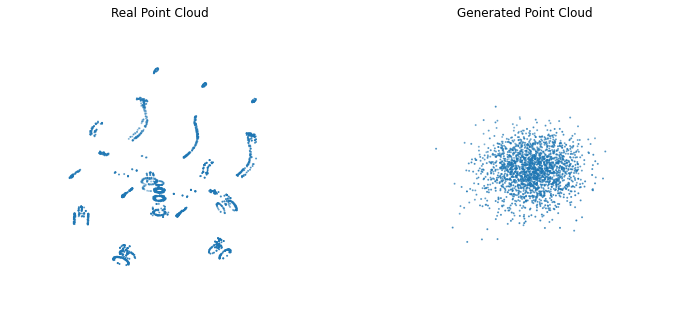


--- Starting Epoch 2/5 ---
GPU Memory: 0.28GB / 3.05GB


 17%|█▋        | 2/12 [00:00<00:03,  3.17it/s]

GPU Memory: 0.28GB / 3.05GB


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

GPU Memory: 0.28GB / 3.05GB


[Epoch 1/5] D loss: 9.0440, G loss: -0.3888

--- Starting Epoch 3/5 ---
GPU Memory: 0.28GB / 3.05GB


 17%|█▋        | 2/12 [00:00<00:02,  3.55it/s]

GPU Memory: 0.28GB / 3.05GB


100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

GPU Memory: 0.28GB / 3.05GB


[Epoch 2/5] D loss: 7.0168, G loss: -0.8408

--- Starting Epoch 4/5 ---
GPU Memory: 0.28GB / 3.05GB


 17%|█▋        | 2/12 [00:00<00:02,  3.51it/s]

GPU Memory: 0.28GB / 3.05GB


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

GPU Memory: 0.28GB / 3.05GB


[Epoch 3/5] D loss: 4.8567, G loss: -1.1992

--- Starting Epoch 5/5 ---
GPU Memory: 0.28GB / 3.05GB


 17%|█▋        | 2/12 [00:00<00:02,  3.53it/s]

GPU Memory: 0.28GB / 3.05GB


100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

GPU Memory: 0.28GB / 3.05GB


[Epoch 4/5] D loss: 3.4590, G loss: -1.4585
Saved checkpoint at epoch 4

Epoch 4 Evaluation:
Chamfer Distance: 0.3389
Earth Movers Distance: 0.0000


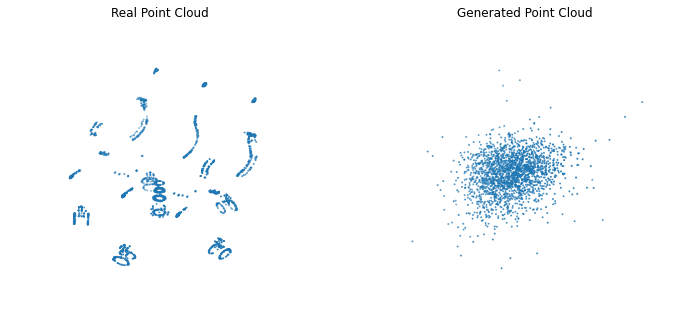

Saved final sample
No training logs found to plot
Could not create interpolation video: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
Created results viewer at results\results_viewer.html
No training logs found to plot

Saved training loss curves to results/

Training completed successfully!
Cleanup complete


In [16]:
if __name__ == "__main__":
    # Create necessary directories
    os.makedirs("results", exist_ok=True)
    os.makedirs("samples", exist_ok=True)
    
    try:
        train_point_cloud_gan()
    except KeyboardInterrupt:
        print("\nTraining manually stopped")
    except Exception as e:
        print(f"\nFatal error in main execution: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        traceback.print_exc()
    finally:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("Cleanup complete")
        #tq3

 Analysis Functions

In [ ]:
def analyze_results(generator, latent_dim, run_dir='results'):
    """Comprehensive analysis with proper device handling and error recovery"""
    # Ensure generator is in eval mode and on correct device
    if generator is not None:
        generator.eval()
        device = next(generator.parameters()).device
    else:
        device = torch.device('cpu')

    try:
        # 1. Plot training curves if logs exist
        plot_training_curves(run_dir)
        
        # 2. Create interpolation video if generator is available
        if generator is not None:
            create_interpolation_video(generator, latent_dim, device, run_dir)
        
        # 3. Always create HTML viewer
        generate_html_viewer(run_dir)
        
    except Exception as e:
        print(f"Analysis partially failed: {str(e)}")
        traceback.print_exc()
    finally:
        # Clean up CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

def plot_training_curves(run_dir):
    """Enhanced training curve plotting with auto log detection"""
    try:
        # Find any CSV log file in directory
        log_files = [f for f in os.listdir(run_dir) if f.endswith('.csv')]
        if not log_files:
            print("No training logs found - run training first")
            return
            
        log_path = os.path.join(run_dir, log_files[0])
        logs = pd.read_csv(log_path)
        
        plt.figure(figsize=(12, 5))
        
        # Plot losses
        plt.subplot(121)
        if 'd_loss' in logs.columns:
            plt.plot(logs['epoch'], logs['d_loss'], label='D Loss')
        if 'g_loss' in logs.columns:
            plt.plot(logs['epoch'], logs['g_loss'], label='G Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training Losses')
        
        # Plot metrics if available
        plt.subplot(122)
        metrics_plotted = False
        if 'chamfer_distance' in logs.columns:
            plt.plot(logs['epoch'], logs['chamfer_distance'], label='Chamfer')
            metrics_plotted = True
        if 'earth_movers_distance' in logs.columns:
            plt.plot(logs['epoch'], logs['earth_movers_distance'], label='EMD')
            metrics_plotted = True
            
        if metrics_plotted:
            plt.xlabel('Epoch')
            plt.ylabel('Metric')
            plt.legend()
            plt.title('Evaluation Metrics')
        else:
            plt.axis('off')
            plt.text(0.5, 0.5, 'No metrics recorded', 
                   ha='center', va='center')
        
        plt.tight_layout()
        plot_path = os.path.join(run_dir, 'training_curves.png')
        plt.savefig(plot_path, bbox_inches='tight', dpi=120)
        plt.close()
        print(f"Saved training curves to {plot_path}")
        
    except Exception as e:
        print(f"Could not plot training curves: {str(e)}")

def create_interpolation_video(generator, latent_dim, device, run_dir, num_frames=60):
    """Robust interpolation video creation with device awareness"""
    temp_dir = os.path.join(run_dir, 'interp_frames')
    os.makedirs(temp_dir, exist_ok=True)
    
    try:
        # Generate latent vectors on correct device
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)
        
        # Create progress bar
        pbar = tqdm(range(num_frames), desc="Rendering interpolation")
        
        for i in pbar:
            alpha = i / (num_frames - 1)  # Ensure we reach exactly z2
            z = (1-alpha) * z1 + alpha * z2
            
            with torch.no_grad():
                pc = generator(z).cpu().numpy()[0]  # Explicit move to CPU
            
            fig = plt.figure(figsize=(6, 6), facecolor='white')
            ax = fig.add_subplot(111, projection='3d')
            
            # Better visualization settings
            ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=2, alpha=0.8)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_zlim(-1, 1)
            ax.set_axis_off()
            ax.set_title(f'Frame {i+1}/{num_frames}', y=0.95)
            
            frame_path = os.path.join(temp_dir, f'frame_{i:03d}.png')
            plt.savefig(frame_path, bbox_inches='tight', dpi=100, 
                       facecolor=fig.get_facecolor())
            plt.close()
        
        # Create video if ffmpeg available
        if shutil.which('ffmpeg'):
            video_path = os.path.join(run_dir, 'latent_interpolation.mp4')
            ffmpeg_cmd = (
                f'ffmpeg -y -framerate 30 -i {temp_dir}/frame_%03d.png '
                '-c:v libx264 -preset slow -crf 18 '
                '-pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" '
                f'{video_path}'
            )
            subprocess.run(ffmpeg_cmd, shell=True, check=True)
            print(f"Created interpolation video at {video_path}")
        else:
            print("ffmpeg not found - saving frames only")
            
    except Exception as e:
        print(f"Video creation failed: {str(e)}")
    finally:
        # Clean up frames unless debugging
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

def generate_html_viewer(run_dir):
    """Robust HTML viewer generation with fallbacks"""
    try:
        # Get all available results
        results = {
            'curves': os.path.join(run_dir, 'training_curves.png'),
            'video': os.path.join(run_dir, 'latent_interpolation.mp4'),
            'samples': []
        }
        
        # Find sample images
        samples_dir = 'samples'
        if os.path.exists(samples_dir):
            results['samples'] = sorted(
                f for f in os.listdir(samples_dir) 
                if f.endswith('.png')
            )
        
        # Generate HTML
        html = f"""
        <html>
        <head>
            <title>3D GAN Results</title>
            <style>
                body {{ font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px; }}
                .section {{ margin-bottom: 40px; border-bottom: 1px solid #eee; padding-bottom: 20px; }}
                .grid {{ display: grid; grid-template-columns: repeat(auto-fill, minmax(300px, 1fr)); gap: 20px; }}
                .card {{ border: 1px solid #ddd; border-radius: 8px; overflow: hidden; }}
                .card img, .card video {{ width: 100%; display: block; }}
                .card-info {{ padding: 15px; }}
                h1 {{ color: #333; }}
                h2 {{ color: #444; margin-top: 0; }}
            </style>
        </head>
        <body>
            <h1>3D GAN Training Results</h1>
        """
        
        # Training curves section
        if os.path.exists(results['curves']):
            html += f"""
            <div class="section">
                <h2>Training Progress</h2>
                <div class="card">
                    <img src="training_curves.png" alt="Training Curves">
                    <div class="card-info">
                        <p>Evolution of losses and metrics during training</p>
                    </div>
                </div>
            </div>
            """
        
        # Interpolation video section
        if os.path.exists(results['video']):
            html += f"""
            <div class="section">
                <h2>Latent Space Interpolation</h2>
                <div class="card">
                    <video controls>
                        <source src="latent_interpolation.mp4" type="video/mp4">
                        Your browser does not support the video tag.
                    </video>
                    <div class="card-info">
                        <p>Smooth transition between random points in latent space</p>
                    </div>
                </div>
            </div>
            """
        
        # Samples section
        if results['samples']:
            html += """
            <div class="section">
                <h2>Generated Samples</h2>
                <div class="grid">
            """
            for img in results['samples']:
                base = os.path.splitext(img)[0]
                html += f"""
                <div class="card">
                    <img src="../samples/{img}" alt="{base}">
                    <div class="card-info">
                        <h3>{base}</h3>
                        <p><a href="../samples/{base}.ply">Download PLY</a></p>
                    </div>
                </div>
                """
            html += """
                </div>
            </div>
            """
        
        html += """
        </body>
        </html>
        """
        
        # Save HTML file
        viewer_path = os.path.join(run_dir, 'results_viewer.html')
        with open(viewer_path, 'w') as f:
            f.write(html)
        print(f"Results viewer created at {viewer_path}")
        
    except Exception as e:
        print(f"Could not generate HTML viewer: {str(e)}")